In [1]:
from astropy.io import fits
from astropy.modeling import models, fitting

import numpy as np
from scipy import optimize
from pathlib import Path
import matplotlib.pyplot as plt

import scipy.stats as stats
from lmfit.models import GaussianModel 
import pprint

In [43]:
data_path = Path("Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\y2024-11-18\BC_Ti_EffArr_1_R04\Analysis\imaging_analysis_20241120\image_reconstruction.fits.gz")
d = fits.open(data_path) # open fits file

data = d[0].data # data contents of the fits file
shape =  data.shape
imPixelSize = 0.0149

y = imPixelSize * np.linspace((shape[0]-1)/-2,(shape[0]-1)/2, shape[0]) # create array from -23 deg to 23 deg, centered on zero
x = imPixelSize * np.linspace((shape[1]-1)/-2,(shape[1]-1)/2, shape[1]) # create array from -41 deg to 41 deg, centered on zero

peak = np.max(data)
peak_loc = np.unravel_index(np.argmax(data),data.shape)
window = 10

x_window =x[peak_loc[1]-window:peak_loc[1]+window]
y_window =y [peak_loc[0]-window:peak_loc[0]+window]

cut = data[peak_loc[0],peak_loc[1]-window:peak_loc[1]+window]

X,Y = np.meshgrid(x[peak_loc[1]-window:peak_loc[1]+window],y[peak_loc[0]-window:peak_loc[0]+window])
windowed_data = data[peak_loc[0]-window:peak_loc[0]+window, peak_loc[1]-window:peak_loc[1]+window]

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\ajo5182\AppData\Local\Temp\ipykernel_31668\318263859.py:1: SyntaxWarning: invalid escape sequence '\A'
  data_path = Path("Z:\Astro_BlackCAT\BlackCAT_Calibration_Data\LC_Calibration_Data\y2024-11-18\BC_Ti_EffArr_1_R04\Analysis\imaging_analysis_20241120\image_reconstruction.fits.gz")


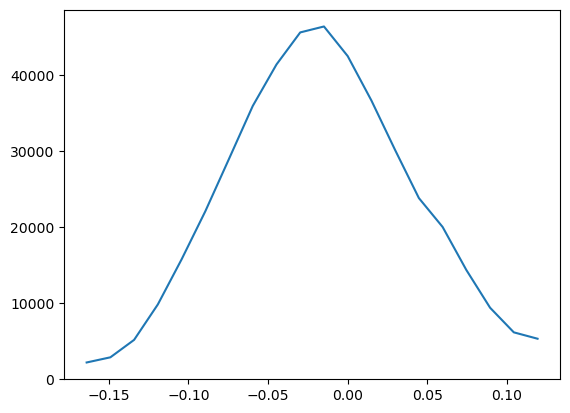

In [64]:
plt.plot(x_window,cut)
plt.savefig('a')

In [41]:
def fit_2d_lorentzian(data, x=None, y=None, plot_result=False):
    """
    Fit a 2d lorenzian to 2D data using Astropy's Gaussian2D model.

    Parameters:
        data : 2D numpy array
            The input data array to fit.
        x, y : 2D numpy arrays, optional
            Meshgrid coordinates corresponding to data. If None, will be auto-generated.
        plot_result : bool
            Whether to plot the original data and fit result.

    Returns:
        fitted_model : Gaussian2D
            The best-fit Gaussian2D model.
    """
    # Generate coordinate grids if not provided
    ny, nx = data.shape
    if x is None or y is None:
        y, x = np.mgrid[:ny, :nx]

    # Estimate initial parameters
    amplitude_init = np.max(data)
    x_mean_init = x[data == amplitude_init][0]
    y_mean_init = y[data == amplitude_init][0]

    # Initial guess for model
    gauss_init = models.Lorentz2D(amplitude=amplitude_init, x_0=x_mean_init,
                                   y_0=y_mean_init, fwhm = 1)

    # Fitting with Levenberg-Marquardt algorithm
    fitter = fitting.LevMarLSQFitter()
    fitted_model = fitter(gauss_init, x, y, data)
    covariance_matrix = fitter.fit_info['param_cov']

    if plot_result:
        fit_data = fitted_model(x, y)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].contour(x,y,data, origin='lower', cmap='viridis')
        axes[0].set_title("Original Data")
        axes[1].contour(x,y,fit_data, origin='lower', cmap='viridis')
        axes[1].set_title("Fitted Lorentzian")
        plt.tight_layout()
        plt.show()

    return fitted_model,covariance_matrix

def rmse(fit,data):
    RMSE = np.sqrt(np.mean(fit-data))
    
    return RMSE

def generate_2d_lorentzian(xi,yi,fwhm, X,Y):
    model = models.Lorentz2D(x_0= xi,y_0 =yi, fwhm=fwhm)
    fit = model(X,Y)
    return fit

def peakcut(data,window):
    peak = np.max(data)
    peak_loc = np.unravel_index(np.argmax(data),data.shape)
    cut = data[peak_loc[0],peak_loc[1]-window:peak_loc[1]+window]
    return cut
    

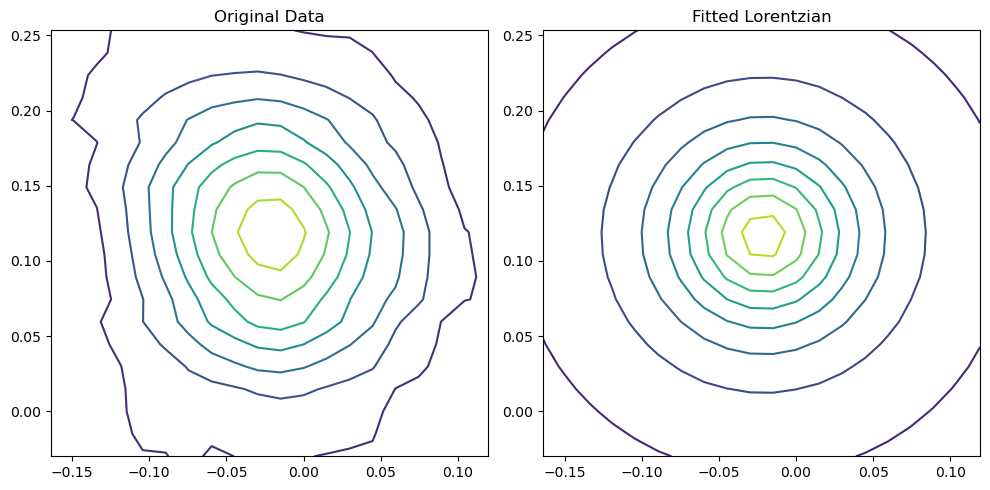

In [45]:
fit = fit_2d_lorentzian(windowed_data, X, Y, plot_result= True)

In [46]:
stats.kstest(windowed_data,stats.cauchy.cdf,alternative= 'two-sided', axis=1)

KstestResult(statistic=array([0.99987167, 0.99988126, 0.99987598, 0.99987946, 0.99991282,
       0.9999104 , 0.99990499, 0.9998549 , 0.99984284, 0.99983517,
       0.99985437, 0.99987341, 0.99991446, 0.99990902, 0.99989698,
       0.99991841, 0.99991613, 0.9999104 , 0.99991136, 0.99991367]), pvalue=array([2.93579406e-78, 6.20454082e-79, 1.48258020e-78, 8.38651061e-79,
       1.28782341e-81, 2.22190802e-81, 7.18370232e-81, 3.42288088e-77,
       1.69058259e-76, 4.38292190e-76, 3.68295287e-77, 2.23464428e-78,
       8.80102319e-82, 3.02037098e-81, 3.62779178e-80, 3.41448976e-82,
       5.93086898e-82, 2.22190802e-81, 1.79518957e-81, 1.05788886e-81]), statistic_location=array([2480.36345653, 2680.81055428, 2566.55570856, 2640.72113473,
       3650.97450738, 3552.75542949, 3350.30386076, 2193.72410674,
       2025.34854463, 1931.13840869, 2185.70622283, 2514.43946314,
       3721.1309916 , 3498.63471309, 3089.72263368, 3901.53337957,
       3795.29641776, 3552.75542949, 3590.84037806, 3687

In [63]:
shapiro_result = stats.shapiro(windowed_data, axis=0)
print(shapiro_result.pvalue)
print(f"mean {np.mean(shapiro_result.pvalue)}")


[0.0812591  0.26041024 0.31374713 0.14152435 0.08938717 0.0582732
 0.07171899 0.08065242 0.06568663 0.06808301 0.07122455 0.07118076
 0.07290197 0.07596565 0.08194496 0.05555004 0.04455788 0.01502973
 0.00264345 0.05070538]
mean 0.08862233055693525


In [ ]:
anderson_result = stats.anderson(cut,dist = 'norm')
print(f"Statistic {anderson_result.statistic}")
print(f"critical val {anderson_result.critical_values}")
print(f"significance {anderson_result.significance_level}")




Statistic 0.5213078138909779
critical val [0.506 0.577 0.692 0.807 0.96 ]
significance [15.  10.   5.   2.5  1. ]
